In [1]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LassoCV

def process_ts_files():
    """
    处理每个年份的ts文件，计算每天11点到14点数据的均值，并保存为新的文件。

    该函数遍历指定年份范围内的每个年份文件夹，找到以'ts'开头且以'.csv'结尾的文件，
    读取这些文件，提取日期和小时信息，筛选出每天11点到14点的数据，计算均值，
    并将结果保存为新的CSV文件，文件名以'mean_'开头。
    """
    base_path = r'C:\Users\97427\Desktop\寒假毕设\result'
    years = [str(year) for year in range(2014, 2021) if year not in [2013]]
    for year in years:
        year_folder = os.path.join(base_path, year)
        ts_files = [file for file in os.listdir(year_folder) if file.startswith('ts') and file.endswith('.csv')]
        for ts_file in ts_files:
            file_path = os.path.join(year_folder, ts_file)
            # 获取化学物质名称（即第二列列名）
            chemical_name = ts_file.split('.')[1]
            # 读取文件
            data = pd.read_csv(file_path, header=0)
            # 以下print语句被注释掉，若后续需要查看读取文件后的数据行数，可取消注释
            print(f"读取文件 {ts_file} 后，数据行数为: {len(data)}")
            data['datetime'] = pd.to_datetime(data['datetime'])
            data = data[data['datetime'].dt.year == int(year)]
            # 以下print语句被注释掉，若后续需要查看去除超出年份数据后剩余行数，可取消注释
            print(f"去除超出 {year} 年份的数据后，剩余行数为: {len(data)}")
            data['date'] = data['datetime'].dt.strftime('%Y%m%d')
            data['hour'] = data['datetime'].dt.hour
            # 按天分组并取11点到14点的第二列数据均值
            mean_data = data[(data['hour'] >= 11) & (data['hour'] <= 14)].groupby('date')[chemical_name].mean().reset_index()
            # 以下print语句被注释掉，若后续需要查看按要求筛选并求均值后的数据行数，可取消注释
            print(f"按要求筛选并求均值后，数据行数为: {len(mean_data)}")
            mean_data.columns = ['date', 'mean_value']
            new_file_name = 'mean_' + ts_file
            new_file_path = os.path.join(year_folder, new_file_name)
            mean_data.to_csv(new_file_path, index=False)



In [2]:
def combine_mean_files():
    """
    合并每个年份每个化学物质的均值数据文件，生成一个包含所有日期和化学物质均值的CSV文件。

    该函数遍历指定年份范围内的每个年份文件夹，找到以'mean_ts'开头且以'.csv'结尾的文件，
    读取这些文件，将均值数据填充到一个包含所有日期和化学物质列的DataFrame中，
    最后将整合后的数据保存为CSV文件。
    """
    base_path = r'C:\Users\97427\Desktop\寒假毕设\result'
    years = [str(year) for year in range(2014, 2021) if year not in [2013]]
    chemical_names = ['ACYE', 'ALK1', 'ALK3', 'ALK4', 'ALK5', 'ARO1', 'ARO2', 'B124', 'BDE13', 'BENZ', 'CFRAC', 'CO',
                      'ETHE', 'HCHO', 'HO2', 'ISOP', 'MXYL', 'NO2', 'O3', 'OH', 'OLE1', 'OLE2', 'OXYL', 'PBL', 'PM10',
                      'PM25_TOT', 'PRECIPITATION', 'PRPE', 'PRSFC', 'Q2', 'RGRND', 'RH', 'SFC_TMP', 'SO2', 'T2', 'TOLU',
                      'WDIR10', 'WSPD10']

    all_dates = []
    # 生成6年的所有日期数据
    # print("开始生成6年的所有日期数据...")
    for year in years:
        for month in range(1, 13):
            for day in range(1, 32):
                date_str = f"{year}{str(month).zfill(2)}{str(day).zfill(2)}"
                try:
                    pd.to_datetime(date_str)
                    all_dates.append(date_str)
                except ValueError:
                    continue
    # print(f"6年所有日期数据生成完成，共 {len(all_dates)} 个日期，示例日期：{all_dates[:5]}")

    # 创建包含所有日期和化学物质列的空DataFrame
    combined_data = pd.DataFrame(columns=['date'] + chemical_names)
    combined_data['date'] = all_dates
    # print("创建空的整合数据DataFrame完成，列名：", combined_data.columns)
    # print("初始整合数据DataFrame示例：")
    # print(combined_data.head())

    for year in years:
        year_folder = os.path.join(base_path, year)
        for chemical_name in chemical_names:
            # 通过前缀和后缀匹配mean文件
            mean_files = [file for file in os.listdir(year_folder) if file.startswith(f"mean_ts.{chemical_name}") and file.endswith('.csv')]
            for mean_file in mean_files:
                mean_file_path = os.path.join(year_folder, mean_file)
                data = pd.read_csv(mean_file_path)
                # print(f"读取 {year} 年 {chemical_name} 对应的mean文件成功，文件路径：{mean_file_path}，数据结构如下：")
                # print(data.info())  # 打印文件数据结构，查看列名和数据类型

                # 将mean文件中的日期列格式统一转换为和combined_data中日期格式一致（字符串形式的YYYYMMDD）
                data['date'] = data['date'].astype(str)
                for index, row in data.iterrows():
                    date_value = row['date']  # 此时是字符串类型，格式为YYYYMMDD
                    mean_value = row['mean_value']
                    # print(f"mean文件中的日期值: {date_value}")
                    # 在combined_data中查找匹配日期的位置，同样按字符串格式YYYYMMDD比较
                    match_index = combined_data[combined_data['date'] == date_value].index
                    if len(match_index) > 0:
                        combined_data.loc[match_index, chemical_name] = mean_value
                        # print(f"已将 {year} 年 {date_value} 的 {chemical_name} 数据填充到整合数据中")
                    else:
                        # print(f"在combined_data中未找到对应 {date_value} 的位置，无法填充数据")
                        continue
    # print("所有年份、所有化学物质数据填充完成，整合数据DataFrame示例：")
    # print(combined_data.head())

    # 使用fillna方法将所有NaN值填充为0（可根据实际情况调整填充值），确保最终文件无缺失值
    combined_data = combined_data.fillna(0)
    # print("填充缺失值完成，整合数据DataFrame示例：")
    # print(combined_data.head())
    combined_data.to_csv('alldata.csv', index=False)



In [3]:
def machine_learning_part():
    """
    机器学习部分，以OH为目标变量，使用整合后的数据进行XGBoost模型训练、参数调优、模型评估以及特征解释等操作。
    """
    # 读取整合后的数据文件
    #使用纯cmaq数据
    # data = pd.read_csv('alldata.csv')
    #使用cmaq和观测数据
    data = pd.read_csv('alldata-instead.csv')
    # 防止python吞位数，将所有数值乘以100000，不影响机器学习
    columns_to_scale = data.columns.difference(['date'])
    data[columns_to_scale] = data[columns_to_scale] * 100000
    # 根据实际特征列名修改特征列列表
    feature_columns_all = ['date','ACYE', 'ALK1', 'ALK3', 'ALK4', 'ALK5', 'ARO1', 'ARO2', 'B124', 'BDE13', 'BENZ', 'CFRAC',
                       'CO', 'ETHE', 'HCHO', 'HO2', 'ISOP', 'MXYL', 'NO2', 'O3', 'OLE1', 'OLE2', 'OXYL', 'PBL', 'PM10', 'PM25_TOT',
                       'PRECIPITATION', 'PRPE', 'PRSFC', 'Q2', 'RGRND', 'RH', 'SFC_TMP', 'SO2', 'T2', 'TOLU', 'WDIR10',
                       'WSPD10']
    feature_columns_shap_best=['HO2', 'SFC_TMP', 'RGRND', 'B124', 'O3', 'ARO2']
    feature_columns_slect = ['date','ACYE', 'ALK1', 'ALK3', 'ALK4', 'ALK5', 'ARO1', 'ARO2', 'B124', 'BDE13', 'BENZ',
                       'CO', 'ETHE', 'ISOP', 'MXYL', 'NO2', 'O3', 'OLE1', 'OLE2', 'OXYL', 'PM10', 'PM25_TOT',
                       'PRPE', 'RGRND', 'RH', 'SO2', 'T2', 'TOLU', 'WDIR10',
                       'WSPD10']
    feature_columns = feature_columns_slect
    X = data[feature_columns]
    y = data['OH']
    print(y)

    # 转换数据类型
    X = X.astype(float)
    y = y.astype(float)

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 定义XGBoost模型
    model = xgb.XGBRegressor()
    # 参数调优的范围
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'colsample_bytree': [0.3, 0.7],
        'lambda': [1, 1.5],  # L2正则化
        'alpha': [0, 0.5],    # L1正则化
    }

    # 使用网格搜索和交叉验证找到最优参数
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # 输出最优参数
    print("最优参数：", grid_search.best_params_)

    # 使用最优参数构建模型
    best_model = grid_search.best_estimator_

    # 交叉验证评估模型
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    print("CV评分:", cv_scores.mean())

    # 使用SHAP解释模型
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_train)

    # 绘制Beeswarm图（需要确保相关绘图库及环境已正确安装配置）
    shap.summary_plot(shap_values, X_train, plot_type="dot") #这里最好设置断点！

    return best_model, X_train, X_test, y_train, y_test, feature_columns, X, y


In [4]:
def stacking_model_part():
    """
    堆叠模型部分，以OH为目标变量，使用整合后的数据进行多模型堆叠，包括XGBoost、RandomForest、
    HistGradientBoosting等模型的组合，通过元学习器进行最终预测。
    """
    # 读取整合后的数据文件
    #使用纯cmaq数据
    # data = pd.read_csv('alldata.csv')
    #使用cmaq和观测数据
    data = pd.read_csv('alldata-instead.csv')
    
    # 防止python吞位数，将所有数值乘以100000，不影响机器学习
    columns_to_scale = data.columns.difference(['date'])
    data[columns_to_scale] = data[columns_to_scale] * 100000
    
    # 根据实际特征列名修改特征列列表
    feature_columns_all = ['date','ACYE', 'ALK1', 'ALK3', 'ALK4', 'ALK5', 'ARO1', 'ARO2', 'B124', 'BDE13', 'BENZ', 'CFRAC',
                       'CO', 'ETHE', 'HCHO', 'HO2', 'ISOP', 'MXYL', 'NO2', 'O3', 'OLE1', 'OLE2', 'OXYL', 'PBL', 'PM10', 'PM25_TOT',
                       'PRECIPITATION', 'PRPE', 'PRSFC', 'Q2', 'RGRND', 'RH', 'SFC_TMP', 'SO2', 'T2', 'TOLU', 'WDIR10',
                       'WSPD10']
    
    # 使用之前选择的最佳特征
    feature_columns_shap_best=['HO2', 'SFC_TMP', 'RGRND', 'B124', 'O3', 'ARO2']
    
    # 根据SHAP值分析结果选择特征
    feature_columns_slect = ['T2', 'O3', 'RGRND', 'NO2', 'RH', 'PM25_TOT', 'WSPD10', 'PM10',
                       'CO', 'ALK1', 'SO2', 'BENZ', 'date', 'ARO2', 'WDIR10', 'OLE2',
                       'ETHE', 'ISOP', 'ALK5', 'ACYE']
    
    feature_columns = feature_columns_slect
    X = data[feature_columns]
    y = data['OH']
    print(y)

    # 转换数据类型
    X = X.astype(float)
    y = y.astype(float)
    
    # 检查并处理NaN值 - 添加此步骤处理缺失值
    X = X.fillna(0)
    y = y.fillna(0)
    
    # 再次检查是否还有NaN值
    print("X中是否存在NaN值：", X.isna().any().any())
    print("y中是否存在NaN值：", y.isna().any())

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 使用已知的最优XGBoost参数
    xgb_best_params = {
        'max_depth': 4,
        'learning_rate': 0.1,
        'n_estimators': 300,
        'colsample_bytree': 0.7,
        'reg_lambda': 1.5,  # lambda参数在XGBoost中是reg_lambda
        'reg_alpha': 0.5    # alpha参数在XGBoost中是reg_alpha
    }
    
    # 定义基础模型，为XGBoost设置已知的最优参数
    base_models = [
        ('xgb', xgb.XGBRegressor(**xgb_best_params, random_state=42)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('hgb', HistGradientBoostingRegressor(max_iter=100, random_state=42)),
        ('lasso', LassoCV())
    ]
    
    # 定义元模型
    meta_model = RidgeCV()
    
    # 创建堆叠模型
    print("创建堆叠模型...")
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,  # 5折交叉验证
        n_jobs=-1  # 使用所有可用CPU核心
    )

    # 直接训练模型，跳过网格搜索
    print("开始训练堆叠模型...")
    stacking_model.fit(X_train, y_train)
    print("堆叠模型训练完成")

    # 交叉验证评估模型
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    print("CV评分:", cv_scores.mean())

    # 使用SHAP解释模型
    print("使用SHAP分析堆叠模型特征重要性...")
    
    # 因为堆叠模型复杂，我们使用base_estimator[0]的SHAP值进行解释
    # 实际中可能需要对每个基础模型分别进行SHAP分析
    first_model = stacking_model.estimators_[0]
    explainer = shap.Explainer(first_model)
    shap_values = explainer(X_train)

    # 绘制Beeswarm图
    shap.summary_plot(shap_values, X_train, plot_type="dot") #这里最好设置断点！

    return stacking_model, X_train, X_test, y_train, y_test, feature_columns, X, y


In [ ]:
def feature_selection_analysis(best_model, X_train, X_test, y_train, y_test, feature_columns):
    sorted_features = feature_columns
    errors = []
#date	ACYE	ALK1	ALK3	ALK4	ALK5	ARO1	ARO2	B124	BDE13	BENZ	CFRAC	CO	ETHE	HCHO	HO2	ISOP	MXYL	NO2	O3	OH	OLE1	OLE2	OXYL	PBL	PM10	PM25_TOT	PRECIPITATION	PRPE	PRSFC	Q2	RGRND	RH	SFC_TMP	SO2	T2	TOLU	WDIR10	WSPD10


    print("开始特征选择分析...")
    for i in range(1, len(sorted_features) + 1):
        print(f"正在处理第 {i} 个特征...")
        selected_features = sorted_features[:i]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # 使用 XGBRegressor 进行训练和预测
        best_model.fit(X_train_selected, y_train)
        predictions = best_model.predict(X_test_selected)
        error = mean_squared_error(y_test, predictions)
        errors.append(error)
    print("特征选择分析完成")

    # 绘制模型性能随特征数量增加的变化图
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(sorted_features) + 1), errors, marker='o', linestyle='-', color='b')
    for i, txt in enumerate(sorted_features):
        plt.annotate(txt, (i + 1, errors[i]), textcoords="offset points", xytext=(0, 10), ha='center', rotation=45)
    plt.title('Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.show() #这里最好设置断点！



In [ ]:
def evaluation_and_plot(best_model, X, X_test, y, y_test):
    # 使用模型对测试集进行预测
    print("开始使用模型对测试集进行预测...")
    y_pred = best_model.predict(X)
    print("测试集预测完成")

    # 计算评价指标：RMSE 和 R²
    print("开始计算评价指标...")
    RMSE = np.sqrt(mean_squared_error(y, y_pred))
    R2 = r2_score(y, y_pred)
    print("评价指标计算完成")

    # 输出 RMSE 和 R²
    # 调整显示精度
    print(f"RMSE: {RMSE:.8f}")
    print(f'R²: {R2:.2f}')

    # 绘制真实值 vs 预测值的散点图
    print("开始绘制散点图...")
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, color='blue', alpha=0.6, edgecolor='k', label="Predictions")

    # 添加 1:1 参考线
    max_value = max(max(y), max(y_pred))
    plt.plot([0, max_value], [0, max_value], 'r--', label="1:1 Line")

    # 设置图表标题和标签
    plt.title('CMAQ Simulation vs Machine Learning Predictions')
    plt.xlabel('CMAQ Simulation')
    plt.ylabel('ML Prediction')

    # 在图上标注 R²、RMSE
    plt.text(0.1 * max_value, 0.9 * max_value, f'R²: {R2:.2f}', fontsize=12)
    # 使用更高的精度显示 RMSE 在图片中
    plt.text(0.1 * max_value, 0.85 * max_value, f'RMSE: {RMSE:.8f}', fontsize=12)

    # 显示图例和网格
    plt.legend()
    plt.grid(True)

    # 显示图表
    print("显示图表")
    plt.show() #这里最好设置断点！

    # 保存新的 CSV 文件
    OH_pre = pd.DataFrame({
        'date': X['date'],
        'y_pred': y_pred
    })
    OH_pre.to_csv('OH_pre.csv', index=False)




0       5.050
1       5.325
2       3.750
3       5.225
4       3.600
        ...  
2552    2.575
2553    4.475
2554    0.925
2555    2.675
2556    2.175
Name: OH, Length: 2557, dtype: float64
X中是否存在NaN值： False
y中是否存在NaN值： False
创建堆叠模型...
开始训练堆叠模型...
堆叠模型训练完成
CV评分: -8.379997201349235
使用SHAP分析堆叠模型特征重要性...


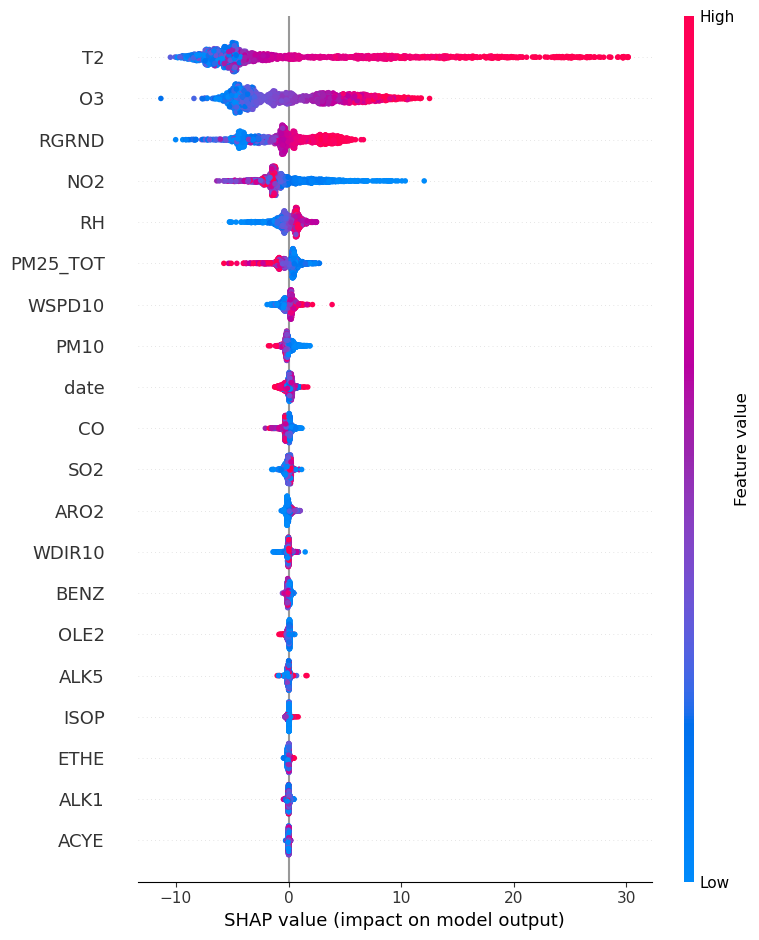

开始使用模型对测试集进行预测...
测试集预测完成
开始计算评价指标...
评价指标计算完成
RMSE: 1.76506587
R²: 0.99
开始绘制散点图...
显示图表


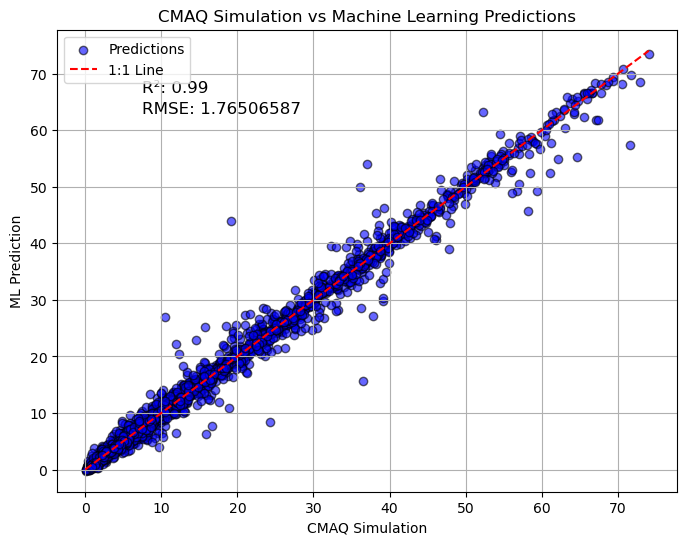

In [ ]:
if __name__ == "__main__":
    # process_ts_files() # 数据处理1
    # combine_mean_files() # 数据处理2
    #best_model, X_train, X_test, y_train, y_test, feature_columns, X, y = machine_learning_part() # xgboost
    best_stacking_model, X_train_stack, X_test_stack, y_train_stack, y_test_stack, feature_columns_stack, X_stack, y_stack = stacking_model_part()# 堆叠模型
    # feature_selection_analysis(best_model, X_train, X_test, y_train, y_test, feature_columns, x) # 特征选择分析
    #evaluation_and_plot(best_model, X, X_test, y, y_test) # 评估xgb模型
    evaluation_and_plot(best_stacking_model, X_stack, X_test_stack, y_stack, y_test_stack) # 评估堆叠模型